# IndiaSim ABM

In [1]:
#import Pkg # for installing packages/package manager
## get packages that are necessary or install them if they don't exist in the current environment
#Pkg.add(["Agents", "Random", "DataFrames", "Distributions", "DrWatson", "Plots","StatsBase",
# "CSV", "DataStructures", "Pickle"])

In [2]:
using Agents, Random, DataFrames, CSV, DataStructures
using Distributions
using DrWatson: @dict
using Plots
using Pickle


In [3]:
#Below function is used to model the transmission rate that decreases by an exponential scale nearing the end of the
    #infection period
function exponential_decay(first,last,steps)
    multiplicative_factor=(last/first)^(1/steps)    
    return multiplicative_factor.^(1:steps).*first
end


exponential_decay (generic function with 1 method)

In [4]:
#Sample individual reproductive number using geometric distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    r_val=0
    try
        r_val=rand(Geometric(1 -Fi_vals[age+1]))+1 * mean_R0
    catch
        #Exception thrown when the agent will have Fi=0. This is because there are no other agents
            #in the district. We assign agent a reproductive number of 0.
        println("Isolated Agent:")
        println(state,district,Fi_vals,Fi_vals[age+1])
    end
    #println("r_val ",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [5]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=Fi_val/(mean_Fi)*mean_R0
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    return r_val
end

R_distribution (generic function with 1 method)

In [6]:
#Next function is the distributions of vaccine efficacy for agent sampling

vaccine_efficacy_low_bound=0.63
vaccine_efficacy_up_bound=0.89

function vaccine_efficacy_dist(lower=vaccine_efficacy_low_bound,upper=vaccine_efficacy_up_bound)
    return rand(Uniform(lower,upper))
end

antibiotics_vaccination_df = DataFrame(CSV.File("antibiotics_childhood_vaccination.csv"))
under_two_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"0-23").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
two_to_five_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_vaccination_abx=antibiotics_vaccination_df[isequal.(antibiotics_vaccination_df[!,"Vaccine"],"PCV") .& isequal.(antibiotics_vaccination_df[!,"Age group (months)"],"24-59").& isequal.(antibiotics_vaccination_df[!,"Outcome against which Protection is Evaluated"],"ARI"),"Estimated VE"][[1,3]] # new data frame
five_plus_factor=(five_plus_vaccination_abx[2]-five_plus_vaccination_abx[1])/2
five_plus_vaccination_abx[1]-=five_plus_factor
five_plus_vaccination_abx[2]+=five_plus_factor

#This function uses agent age and reproductive number; it calculates tranmission rate by day for each day of infection.
    #It also determines whether the agent will die, and days of infection until death if so, and whether the agent
    #will take antibiotics, and the day if so.
function transmission_rate(age, wealth, vaccine_efficacy, R0_mean, Fi_vals,state,district, mean_Fi,days_incubate=rand(1:3),days_increase=rand(1:5),
    days_decrease_linear=rand(3:9), days_decrease_exponential=rand(5:25))   
    
    #Scaling the reproductive number based on differential # of contacts by age
    #scales mean R0 by total contacts given agent age using gamma distribution sampling
    reproductive_number=R_distribution(age,R0_mean,Fi_vals,state,district,mean_Fi)    
    
    if age<5#carriage rate data from https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0246522&type=printable
        
        if age<2
            if age<1
                carriage_prob=0.152
            else
                carriage_prob = 0.019
            end
        else
            carriage_prob=0.004
        end
    else
        carriage_prob=0
    end
    
    carrier = false
    #Below if statement determines whether agent is a carrier and will have the transmissible infection for a 
        #prolongued period of time
    
    
    #This is the transmission rate if the agent is not a carrier, adding additional transmission days in if statement below 
            #if agent is a carrier  
    
    days_carrier=0
    
    if rand(Uniform(0,1))<carriage_prob
        days_carrier = trunc(Int,round(1/(rand(Uniform(0.64,0.75))/30)))-(days_increase+days_decrease_linear+days_decrease_exponential) 
        carrier = true
        #monthly carriage clearance data from https://doi.org/10.1186/1471-2334-9-102. Accounting for all other days of infection
        #that technically count as carriage (aside from incubation period)
        
        #If a carrier, the reproductive number is 1 over the remaining days of carriage (note the 1/days_carrier)
    end
    
    transmission_scale = Vector{Float64}(undef,days_incubate+days_increase+days_decrease_linear+days_decrease_exponential+days_carrier)
    
    trans_index=1
    
    for i in zeros(days_incubate)
        transmission_scale[trans_index]=i
        trans_index+=1
    end   
        
    if days_increase<2
        transmission_scale[trans_index]=1
        trans_index+=1

    else
        for i in LinRange(0,1,days_increase+1)[2:days_increase+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end
    
    if days_decrease_linear<2
        transmission_scale[trans_index]=rand(Uniform(1/3,2/3))
        trans_index+=1
    else
        for i in LinRange(1,rand(Uniform(1/3,2/3)),days_decrease_linear+1)[2:days_decrease_linear+1] #Need to add 1 to function because LinRange adds 0 as first value, then index 2: to remove 0
            transmission_scale[trans_index]=i
            trans_index+=1
        end
    end

    for i in exponential_decay(transmission_scale[trans_index-1],rand(Uniform(1/100,1/5)),days_decrease_exponential)
        transmission_scale[trans_index]=i
        trans_index+=1
    end 
    
    transmission_scale=transmission_scale.*(reproductive_number/sum(transmission_scale[1:trans_index-1]))
    
    if days_carrier>0
        for i in repeat([1/days_carrier],days_carrier)
            transmission_scale[trans_index]=i
            trans_index+=1
        end 
    end  
    
    #default is no antibiotics; if agent is not a carrier, will seek antibiotics. Chance of seeking antibiotics if vaccinated
    days_till_antibiotic=-1
    
    if carrier==false #If not carrier, agent will seek antibiotics 1-5 days after onset of symptoms
        if vaccine_efficacy>0 #If vaccinated, transmission rate and death probability are reduced; below is also
                                #the probability they will seek antibiotics (based on age)
            transmission_scale.*0.75 #reduced transmission rate by arbitrary 25%
            
            if age<2
                if age<1 #if 0-1 yrs old
                    #Accounting for the -0.066 in the CI of -0.066 to 0.19
                    if vaccine_efficacy<vaccine_efficacy_low_bound+
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(under_two_vaccination_abx[1])/
                        (abs(under_two_vaccination_abx[1])+under_two_vaccination_abx[2])
                        days_till_antibiotic=days_incubate + rand(1:5)

                    elseif rand(Uniform(0,1))> rand(Uniform(under_two_vaccination_abx[1],under_two_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)
                    end
                
                    #if 2-5 years old
                
                elseif rand(Uniform(0,1))> rand(Uniform(two_to_five_vaccination_abx[1],two_to_five_vaccination_abx[2])) 
                        days_till_antibiotic=days_incubate + rand(1:5)
                end
            #if 5+ years old
            elseif vaccine_efficacy<vaccine_efficacy_low_bound+ #Accounting for negative lower bound here as well
                            (vaccine_efficacy_up_bound-vaccine_efficacy_low_bound)*abs(five_plus_vaccination_abx[1])/
                        (abs(five_plus_vaccination_abx[1])+five_plus_vaccination_abx[2])
                
            elseif rand(Uniform(0,1))> rand(Uniform(five_plus_vaccination_abx[1],five_plus_vaccination_abx[2]))#Probability sourced from:https://www.nature.com/articles/s41586-020-2238-4 (Roughly symmetric CIs)
                        days_till_antibiotic=days_incubate + rand(1:5)

            end
        
        else #if not vaccinated, seek antibiotics according to wealth quintile
            

            antibiotics_outcome = rand(Uniform(0,1))
            
            #Below if statement: agent has variable probability to be administered antibiotics based on wealth quintile
            
            if (wealth==5 && antibiotics_outcome<0.5) || (wealth==4 && antibiotics_outcome<0.4) || (wealth==3 && antibiotics_outcome<0.3) || 
                (wealth==2 && antibiotics_outcome<0.25) || (wealth==1 && antibiotics_outcome<0.2)
                
                days_till_antibiotic=days_incubate + rand(1:5)
            end
        end
    end
        
            
    if age>5 #Death probability from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/
        death_prob =0.041333
    else
        death_prob = 0.04247
    end
    
    #vaccinated arbitrarily die at 75% of probability of unvaccinated, 0% probability if they don't seek antibiotics
    if vaccine_efficacy>0 
        if days_till_antibiotic != -1
            death_prob*=0.75 
        else
            death_prob=0
        end
    end
                
    
    if rand(Uniform(0,1))<death_prob
        days_till_death= days_incubate+rand(10:30) #data according to the bacterial kinetics model and https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3167921/pdf/793.pdf
    else
        days_till_death=-1 #agent will not die
    end
    
    #With current parameters, infection period lasts anywhere between 10-50 days
    return [transmission_scale,days_till_death,days_till_antibiotic]
end

transmission_rate (generic function with 5 methods)

In [7]:
transmission_sample=zeros(10^6)

for i in 1:10^6
    transmission_sample[i]=length(transmission_rate(rand(0:12), rand(1:5), NaN, NaN, repeat([NaN],13),"NaN","NaN", NaN)[1])
end

        
avg_transmission_duration=mean(transmission_sample)

26.275599

In [8]:
# @agent PoorSoul GraphAgent begin # then can drop the pos

mutable struct PoorSoul <: AbstractAgent 
    id::Int
    day_of_infection::Int  # How far along infection a sick individual is (accelerated w/ antibiotics)
    days_infected::Int #Number of agent has been sick
    status::Symbol
    ever_infected::Bool #Whether agent has ever been infected
    transmission::Array{Float64,1} #Agent-level tranmission for each of the the days agent is infected.
    vaccine_efficacy::Float64 #Probability for successfully transmitted disease to infect the agent is 1-vaccine_efficacy
    days_till_death::Int #Either an integer of the days infected until death, or "-1" if agent won't die.
                            #assigned at start of simulation, probability given by proportion of infected that die when sick. 
    days_till_antibiotic::Int #Either an integer of the # of days into infected until an agent seeks antibiotics, or "-1"
                                #if the agent will not be seeking antibiotics (will not be seeking if agent is not
                                #infected or if the agent has been infected and is treated with effective antibiotics)
    
    antibiotics_treated_with::Array{String,1} #The antibiotics a currently-infected agent has tried
    
    serotype_immunity::Array{Int,1} #Contains the serotypes the agent has been infected with and is now immune to.
    
    high_prev_serotype::Bool #Whether or not agent was ever infected by one of serotypes 1-32. We record this to
                                #simplify computations for reinfection probability
    age_cat::Int
    days_age_cat::Int #Days passed as agent is in the same age category (every 365 days, age incremented by one) 
    wealth_cat::Int
    state::String
    district::Int
    serotype::Int
    travel_return_stats::Array{Any,1} #Array to hold information if the agent takes a trip outside of current state district and will return
end

In [9]:
# parameters for the transmission of the infection
# the key idea is to have a modular design so that we can easily flip and flip out new pathogens
function model_initiation(;
    R0_mean,
    vaccine_efficacy_distribution,
    serotypes,
    serotype_prevalence,
    states_districts,
    district_growth_rate,
    daily_growth,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    state_vacc_info,
    state_spneumoniae_prevalence,
    seed =rand(1:100000),
    R0_by_day
)

    
    rng = MersenneTwister(seed)
    
    #killed_agents = Int[] #Gather the position IDs of dead agents by district 
    
    pop_by_state = Dict{String,Int}() #Monitor population by state every step
    cases_by_state = Dict{String,Int}() #Monitor cases by state every step
    prop_infected_by_state = Dict{String,Float64}() #Monitor proportion infected every step
    
    N_total=0
    for state in keys(states_districts)
        for district in states_districts[state]
            N_total+=states_districts_pop[(state,district)]
        end
    end
    
    avg_transmission_by_state=Dict{String,Float64}() #The average transmission rate of infected by state for the current day
    antibiotics_by_day=Int[0]
    cumulative_deaths=Int[0]
    step=1
    community_transmitted=0 #recording to analyze dynamics
    contact_transmitted=0 #recording to analyze dynamics
    
    
    states_districts_contact_matrices =Dict{Tuple{String,Int},Matrix{Float64}}()
    
    available_ages_states_districts = Dict{Tuple{String,Int},Vector{Int64}}()
    
    states_districts_ages_ids = DefaultDict{Tuple{String,Int},Dict{Int64,Vector{Int64}}}(()->Dict{}())
    
    deaths_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    replace_unvac_by_district_step = Dict{Tuple{String,Int},Int64}()

    replace_vac_by_district_step = Dict{Tuple{String,Int},Int64}()
    
    
    total_agents_ever_added_naturally=Dict{Tuple{String,Int},Int}()
    
    mean_Fi=0
        
    agents_to_add_total_natural=0
    agents_to_add_total_vac=0
    agents_to_add_total_unvac=0
    
    total_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    infections_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    antibiotics_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    cumulative_deaths_quintiles=Vector{Int}[[0],[0],[0],[0],[0]]
    
    total_added_naturally_per_state = Dict{String,Int64}()
    total_ever_cases_per_state = Dict{String,Int64}()
    total_ever_abx_per_state= Dict{String,Int64}()
    
    total_cases_per_state_steady_state = Dict{String,Int64}()
    total_abx_per_state_steady_state = Dict{String,Int64}()
    
    total_cases_per_quintile_steady_state = Dict{Int64,Int64}()
    total_abx_per_quintile_steady_state = Dict{Int64,Int64}()

    infection_duration = Int[]
    
    duration_steady_state=Int64(0)
    
    properties = @dict(
    pop_by_state,
    cases_by_state,
    prop_infected_by_state,
    R0_mean,
    vaccine_efficacy_distribution,
    #killed_agents,
    state_spneumoniae_prevalence,
    serotypes,
    serotype_prevalence,
    states_districts,
    states_districts_pop,
    states_districts_info,
    ids_states_districts,
    states_districts_ages_ids,
    avg_transmission_by_state,
    antibiotics_by_day,
    cumulative_deaths,
    community_transmitted,
    contact_transmitted,
    available_ages_states_districts,
    step,
    state_vacc_info,
    district_growth_rate,
    daily_growth,
    deaths_by_district_step,
    replace_unvac_by_district_step,
    replace_vac_by_district_step,
    states_districts_contact_matrices,
    total_agents_ever_added_naturally,
    mean_Fi,
    N_total,
    agents_to_add_total_natural,
    agents_to_add_total_vac,
    agents_to_add_total_unvac,
    total_quintiles,
    infections_quintiles,
    antibiotics_quintiles,
    cumulative_deaths_quintiles,
    total_added_naturally_per_state,
    total_ever_cases_per_state,
    total_ever_abx_per_state,
    infection_duration,
    total_cases_per_state_steady_state,
    total_abx_per_state_steady_state,
    duration_steady_state,
    total_cases_per_quintile_steady_state,
    total_abx_per_quintile_steady_state,
    R0_by_day
    )
    
    model = ABM(PoorSoul; properties, rng)
    
    tot_each_age=Dict{Int,Int}()
    for age in 0:12
        tot_each_age[age]=0
    end
 
    
    #Predefining age distributions by district
    ages=Int[]
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        state_transmissions=Float64[]
        
        
        for district in states_districts[state]
            
            index_age=1
            
            try
                ages_district=Vector{Int}(undef,states_districts_pop[(state,district)])

            
                poss_ages,age_props=0:12,states_districts_info[(state,district)]["proportion_pop_by_age"]

                for n in 1:states_districts_pop[(state,district)]
                    
                    age_cat = poss_ages[rand(DiscreteNonParametric(1:13,age_props))]
                    ages_district[index_age]=age_cat
                    tot_each_age[age_cat]+=1
                    
                    index_age += 1
                end
                append!(ages,ages_district)
            catch #if population is 0
            end
        end
    end
    
    
    tot_Fi_vals=Float64[]
    
    #Generating contact matrices using pre-defined ages
    for state in keys(states_districts)
                
        for district in states_districts[state]
            
            contact_matrix=zeros(13,13)           
            
            #println(state,district,states_districts_info[(state,district)]["proportion_pop_by_age"])
            for age1 in 1:13
                for age2 in 1:13
                    N_total=states_districts_pop[(state,district)]
                    
                    #contact matrix is computed using same formula as F matrix from https://www.nature.com/articles/s41467-020-20544-y
                    val= (((N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age1])*
                            (N_total*states_districts_info[(state,district)]["proportion_pop_by_age"][age2]-
                                kronecker_delta(age1,age2)))/(N_total-1))/(tot_each_age[age1-1])
                    
                    #println(state,district,"&",N_total-1, "&",tot_each_age[age1-1])
                    #println(val)
                    if isnan(val)#If no agents of an age
                        contact_matrix[age1, age2] =0
                    elseif val>0
                        contact_matrix[age1, age2] =val
                    else #sometimes computed value is has a very small magnitude below 0.
                        contact_matrix[age1, age2] =0
                    end
                end
            end
      
       
            #Adding Fi_vals specific to district
            #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
            Fi_vals=Vector{Float64}(undef,13) #probability for an agent of each age to contact any one individual (in chronological order by age)

            for agei in 1:13
                Fi=0
                for age_contacted in 1:13
                    Fi+=contact_matrix[age_contacted,agei]*
                    (states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                end
                if Fi<1
                    Fi_vals[agei]=Fi
                else
                    Fi_vals[agei]=0.9999 #Just a safety measure for p if it ends up at 1
                end
            end
            
            #println(Fi_vals)
            states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
            
            # normalize migration_rates
            contact_matrix_sum = sum(contact_matrix, dims = 1)
            for c in 1:13 
                contact_matrix[:, c] ./= contact_matrix_sum[c]
            end
                    
            #Adding contact matrices specific to districts to separate data structure
            states_districts_contact_matrices[state,district]=contact_matrix
            
        end
    end
    
    for i in 1:5
        total_cases_per_quintile_steady_state[i]=0
        total_abx_per_quintile_steady_state[i]=0
    end
    
    agent_id=1
    for state in keys(states_districts)        
        
        for district in states_districts[state]
            
 

            for n in 1:states_districts_pop[(state,district)]
                
                push!(tot_Fi_vals,states_districts_info[(state,district)]["Fi_vals"][ages[agent_id]+1])
                
            end
        end
    end
    
    model.mean_Fi=mean(tot_Fi_vals)

    
    #adding agents in by district
    agent_id=1
    for state in keys(states_districts)
        
        #Recording incidence of disease by state
        cases_by_state[state]=0
        pop_by_state[state]=0
        
        state_transmissions=Float64[]
                    
        total_added_naturally_per_state[state]=0
        total_ever_cases_per_state[state]=0
        total_ever_abx_per_state[state]=0
        
        total_cases_per_state_steady_state[state]=0
        total_abx_per_state_steady_state[state]=0
        
        
        
        for district in states_districts[state]
            
            
            total_agents_ever_added_naturally[(state,district)]=0
            
            poss_wealth,wealth_props=1:5,states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
            for age_category in 0:12
                states_districts_ages_ids[(state,district)][age_category] = []
            end
            
            for n in 1:states_districts_pop[(state,district)]
                
                
                
                push!(ids_states_districts[(state,district)],agent_id)

                
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                age_cat=ages[agent_id]
                
                days_age_cat = rand(1:364)
                
                
                total_agents_ever_added_naturally[(state,district)]+=1
                
                                    
                push!(states_districts_ages_ids[(state,district)][age_cat],agent_id)
                
                agent_id+=1
                
                model.pop_by_state[state]+=1
                
                vaccine_efficacy= 0 #In this version of the model, no agents are vaccinated
                
                model.total_quintiles[wealth_cat][model.step]+=1
                            
                if rand(rng) <= state_spneumoniae_prevalence[state]   #if sick
                    cases_by_state[state]+=1     
                    
                    #assigned serotype agent is infected with
                    serotype=rand(DiscreteNonParametric(serotypes,serotype_prevalence)) 
                                        
                    if serotype in 1:32 #Whether or not agent has been infected with a high-prevalence serotype
                        high_prev_serotype=true
                    else
                        high_prev_serotype=false
                    end
                                          
                    #agent transmission rate, days until death, whether agent is a carrier
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(age_cat,wealth_cat,
                        vaccine_efficacy,R0_mean,states_districts_info[(state,district)]["Fi_vals"],state,district,model.mean_Fi) 
                    
                    push!(state_transmissions,transmission_by_day[1])
                    
                    serotype_immunity = Vector{Int}(undef,112)
                    serotype_immunity[serotype]=serotype
                    
                    ind = add_agent!(model,1,1,:I,true,transmission_by_day,vaccine_efficacy,
                        days_till_death,days_till_antibiotic,String[],serotype_immunity,high_prev_serotype,age_cat,days_age_cat,wealth_cat,state,district,serotype,
                    [NaN,NaN,-1])
                    
                    model.infections_quintiles[wealth_cat][model.step]+=1
                    
                    model.total_ever_cases_per_state[state]+=1
                    
                else #if healthy
    

                    ind = add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                    String[],Vector{Int}(undef,112),false,age_cat,days_age_cat,wealth_cat,state,district,0,[NaN,NaN,-1])
                end
            end
        end
         

        prop_infected_by_state[state] = cases_by_state[state]/pop_by_state[state]
        try
            avg_transmission_by_state[state]=sum(state_transmissions)/length(state_transmissions)
        catch
            avg_transmission_by_state[state]=0 #(pop in state is 0)
        end
    end
    

    
    return model
end

model_initiation (generic function with 1 method)

In [10]:
function kronecker_delta(i,j)
    i==j && return 1
    return 0
end

kronecker_delta (generic function with 1 method)

10% of agents, 100 times greater disease incidence, antibiotic probabiity had been adjusted

In [11]:
function R0_by_day_func(first_value,last_value, days_between)
    
    if days_between%1>0
        count_days_between=days_between-0.5
    else
        count_days_between=days_between
    end
    
    R0_by_day_return=Float64[first_value]
    
    increment_factor=(last_value-first_value)/count_days_between
        
    for i in 1:trunc(Int,round(count_days_between))
        push!(R0_by_day_return,R0_by_day_return[i]+increment_factor)
    end        
    return(R0_by_day_return)
end

R0_by_day_func (generic function with 1 method)

In [12]:
function create_params(;
    total_agents=100000, #Total agents in the model
    R0_mean=1.4,#average reproductive number of the disease
    vaccine_efficacy_distribution = vaccine_efficacy_dist, #Distribution of vaccine efficacy on agent basis
    serotypes=1:112,
    serotype_prevalence=append!(repeat([0.8/32],32),repeat([0.2/(112-32)],112-32)), #Prevalence of the serotypes in the serotypes array (chronological order)
    states_districts=Dict{String,Vector{Int}}(),
    states_districts_info = DefaultDict{Tuple{String,Int},Dict{String,Vector{Float64}}}(()->Dict{}()),
        #Contact matrices in separate data structure so that the different array types can be specified 
        #for most efficient computing
    states_districts_pop=Dict{Tuple{String,Int},Int}(), #Integer of population by state
    ids_states_districts = Dict{Tuple{String,Int},Vector{Int}}(), #How we determine id of agents that may be infected, given their position in contact matrix 
    state_vacc_info=Dict{String,Vector{Float64}}(), #proportion vaccinate by wealth in order 1,2,3,4,5
    state_spneumoniae_prevalence=Dict{String,Float64}(), #Incidence of S. pneumoniae by Indian state
    seed = rand(1:100000),
        
)
    
    wealthq_by_district_df = DataFrame(CSV.File("wealthq_data_condensed.csv"))
    quintile_probs = [Matrix(wealthq_by_district_df)[i,:][3:7] for i in 1:length(Matrix(wealthq_by_district_df)[:,1])]
    num_districts_by_state = Dict{String,Int}()

    vaccination_df = DataFrame(CSV.File("vaccination_data_condensed.csv"))
    incidence_by_state_df = DataFrame(CSV.File("s.pneumoniae_incidence_estimates.csv"))

    #Filling up states_districts dict, proportion_pop_by_wealth
    for state in Set(wealthq_by_district_df.state_name)
        num_districts_by_state[state]=0
        for district in wealthq_by_district_df[isequal.(wealthq_by_district_df[!,"state_name"],state),"district_no"]        
            try
                    states_districts[state]=push!(states_districts[state],district)
            catch 
                    states_districts[state]=[district]
            end
            num_districts_by_state[state]+=1
            
            states_districts_info[(state,district)]["proportion_pop_by_wealth"]=quintile_probs[district]
            
        end
    end
    
    for state in keys(states_districts)
        state_vacc_info[state]=vec(Array{Float64}(vaccination_df[isequal.(vaccination_df[!,"state_name"],state),["vaccinate_wealthq_1","vaccinate_wealthq_2","vaccinate_wealthq_3","vaccinate_wealthq_4","vaccinate_wealthq_5"]]))
        

        
        if state in incidence_by_state_df[!,"Indian State"]
            state_spneumoniae_prevalence[state]=parse(Float64,split(incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],state),["Pneumococcal Pneumonia Episodes (Thousands)"]][!,"Pneumococcal Pneumonia Episodes (Thousands)"][1]," ")[1])*1000/
            incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],state),["Population aged 0-5 years"]][!,"Population aged 0-5 years"][1]*
            (avg_transmission_duration/365)#Prevalence is approximated as daily incidence times days of infection period
        else
            state_spneumoniae_prevalence[state]=parse(Float64,split(incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],"all india"),["Pneumococcal Pneumonia Episodes (Thousands)"]][!,"Pneumococcal Pneumonia Episodes (Thousands)"][1]," ")[1])*1000/
            incidence_by_state_df[isequal.(incidence_by_state_df[!,"Indian State"],"all india"),["Population aged 0-5 years"]][!,"Population aged 0-5 years"][1]*
            (avg_transmission_duration/365)#Prevalence is approximated as daily incidence times days of infection period
        
        end
    end

    total_pop=0
    district_growth_rate = Dict{Tuple{String,Int},Float64}()
    daily_growth = Dict{Tuple{String,Int},Float64}()
    district_pops_df = DataFrame(CSV.File("district_populations_extrapolated.csv"))
    for state in keys(states_districts)
        
        #Sample from log norm of pops/growth rates, scaled by # of districts per state changed over time
        
        num_districts_in_past = length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"])
        
        #If more than 1 district in state, we have a distribution
        if length(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"])>1
            min_pop=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"].*(num_districts_in_past/num_districts_by_state[state]))
            mu,sigma=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"].*(num_districts_in_past/num_districts_by_state[state]).-min_pop.+1))
            min_growth=minimum(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]))
            mu2,sigma2=Distributions.params(fit(LogNormal,district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"].*(num_districts_in_past/num_districts_by_state[state]).-min_growth.+0.01))
            #sample district pop, growth rate
            for district in states_districts[state]
                states_districts_pop[(state,district)]=trunc(Int,round(rand(LogNormal(mu,sigma))+min_pop-1))
                #if the -1 in above formula causes sampled population to be less than 0 (-1), round up to 0:
                if states_districts_pop[(state,district)]<0;  states_districts_pop[(state,district)]=0; end
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = rand(LogNormal(mu2,sigma2))+min_growth-0.01
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                #limit growth rate... too high growth rate and starting population skews Fi vals to be >1
                if district_growth_rate[(state,district)]>1.9
                    
                    #district_growth_rate[(state,district)] =1.9
                end
                proportions_age=district_growth_rate[(state,district)].^reverse(1:13)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        else
            for district in states_districts[state]
                states_districts_pop[(state,district)] = trunc(Int,round(district_pops_df[isequal.(district_pops_df[!,"State"],state),"Population_log"][1]*(num_districts_in_past/num_districts_by_state[state])))
                total_pop+=states_districts_pop[(state,district)]
                district_growth_rate[(state,district)] = district_pops_df[isequal.(district_pops_df[!,"State"],state),"Growth Rate"][1]*(num_districts_in_past/num_districts_by_state[state])
                if district_growth_rate[(state,district)]>1
                    daily_growth[(state,district)]=(district_growth_rate[(state,district)])^(1/365)-1
                else
                    daily_growth[(state,district)]=1-(district_growth_rate[(state,district)])^(1/365)
                end
                
                proportions_age=district_growth_rate[(state,district)].^reverse(1:13)
                proportions_age=proportions_age./sum(proportions_age)
                states_districts_info[(state,district)]["proportion_pop_by_age"]=proportions_age
            end
        end
    end
        

    Random.seed!(seed)
    
    #scaling total pop to # total_agents
    for state in keys(states_districts)
        for district in states_districts[state]
            states_districts_pop[(state,district)]=trunc(Int,round(states_districts_pop[(state,district)]*total_agents/total_pop))
            ids_states_districts[(state,district)]=Int[]
        end
    end
    
    day_R0_last_next=Vector{Vector{Float64}}(undef,0)
    for (last,next) in zip([median(1:31),median(32:59),median(60:90),median(91:120),median(121:151),median(152:181),median(182:212),median(213:243),median(244:273),median(274:304),median(305:334),median(335:365)],
            [median(32:59),median(60:90),median(91:120),median(121:151),median(152:181),median(182:212),median(213:243),median(244:273),median(274:304),median(305:334),median(335:365),median(1:31)])
    push!(day_R0_last_next,[last,next])
    end
    
    
    rel_transmission_df=DataFrame(CSV.File("Relative S. pneumoniae transmission.csv"))
    rel_transmission_set1=rel_transmission_df[!," Relative Transmission"]
    rel_transmission_set2=push!(rel_transmission_set1[2:length(rel_transmission_set1)],rel_transmission_set1[1])
    
    R0_val_last_next=Vector{Vector{Float64}}(undef,0)
    for (last,next) in zip(rel_transmission_set1, rel_transmission_set2)
        push!(R0_val_last_next,[last,next]) 
    end
        

    R0_by_day=zeros(365)
    
    for (day,R0) in zip(day_R0_last_next,R0_val_last_next)
        
        if R0[1]%1>0
            index = index=trunc(Int,round(day[1]))+1
        else
            index=trunc(Int,round(day[1]))
            R0_by_day[trunc(Int,round(day[1]))]=R0[1]
        end
        
        
        
        if day[2]>day[1]
            days_between=day[2]-day[1]
        else
            days_between = 365-day[1]+day[2]
        end
        
        if R0[1]%1>0
            days_between+=1
        end
        
        vals_input = R0_by_day_func(R0[1],R0[2],days_between)
        
        for i in vals_input
            R0_by_day[index]=i
            index+=1
            if index>365
                index=1
            end
        end
    end
        
    parameters = @dict(
        R0_mean,
        vaccine_efficacy_distribution,
        states_districts_pop,
        serotypes,
        serotype_prevalence,
        states_districts,
        states_districts_info,
        state_vacc_info,
        state_spneumoniae_prevalence,
        ids_states_districts,
        district_growth_rate,
        daily_growth,
        R0_by_day)

    return parameters
end

@time parameters = create_params()
@time model = model_initiation(; parameters...)

  9.802980 seconds (10.71 M allocations: 488.090 MiB, 2.31% gc time, 97.53% compilation time)
  4.306320 seconds (4.70 M allocations: 252.469 MiB, 2.35% gc time, 98.28% compilation time)


AgentBasedModel with 1040 agents of type PoorSoul
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: cumulative_deaths, total_added_naturally_per_state, replace_vac_by_district_step, total_ever_abx_per_state, total_abx_per_state_steady_state, agents_to_add_total_natural, antibiotics_by_day, state_vacc_info, agents_to_add_total_unvac, cases_by_state, ids_states_districts, daily_growth, replace_unvac_by_district_step, infection_duration, vaccine_efficacy_distribution, mean_Fi, total_abx_per_quintile_steady_state, states_districts_pop, antibiotics_quintiles, total_agents_ever_added_naturally, community_transmitted, total_cases_per_state_steady_state, cumulative_deaths_quintiles, R0_mean, state_spneumoniae_prevalence, avg_transmission_by_state, total_ever_cases_per_state, deaths_by_district_step, contact_transmitted, total_quintiles, states_districts_info, states_districts_ages_ids, serotype_prevalence, total_cases_per_quintile_steady_state, serotypes, prop_infected_by

### Our model simulates increasing dominance of virulent strains over time, until new mutants emerge that may circumvent the vaccine and immune-primed defenses (we have not modeled emergence of novel strains however)

In [13]:
function complex_step!(model)
    
    general_daily_updates!(model)
    
    seasonality!(model)
    
    #Need each agent to do complete some activities before proceeding to next activities
    for agent_id in keys(model.agents)
        community_transmit!(model,agent_id)
    end 

    
    for agent_id in keys(model.agents)
        transmit!(model,agent_id)
    end 

    for agent_id in keys(model.agents)
       antibiotics!(model,agent_id)
       recover_or_die!(model,agent_id)
    end
                
    for agent_id in keys(model.agents)
        days_sick_update!(model,agent_id)
    end    
          
    for agent_id in keys(model.agents)
        travel!(model,agent_id)
        travel_return!(model,agent_id)
    end
    
    births!(model)

    #Daily growth rate moves ~10% closer to the mean per year:
    daily_growth_tot=0
    total_districts=0
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            daily_growth_tot+=model.daily_growth[(state,district)]
            total_districts+=1
        end
    end
    
    avg_daily_growth=daily_growth_tot/total_districts
            
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            if model.daily_growth[(state,district)]>avg_daily_growth
                model.daily_growth[(state,district)]-=0.1/365*(model.daily_growth[(state,district)]-avg_daily_growth)
            else
                model.daily_growth[(state,district)]+=0.1/365*(avg_daily_growth-model.daily_growth[(state,district)])
            end
        end
    end
    
    model.step+=1
    
    if model.step==366
        initialize(model) #end burn-in period
    end
    
end    

function initialize(model)
    
    ratio_recovered_infected=0
    
    
    
    for state in keys(model.states_districts)
        model.total_ever_cases_per_state[state]=0
        model.total_ever_abx_per_state[state]=0
        for district in model.states_districts[state]
            tot_infected=0
            tot_recovered=0
            
            
            model.cumulative_deaths[model.step]=0
            
            for wealth_quintile in 1:5
                model.cumulative_deaths_quintiles[wealth_quintile][model.step]=0 
            end
            
            model.cases_by_state[state]=0
            
            
            for agent_id in model.ids_states_districts[(state,district)]
                try
                    if model[agent_id].status==:I
                        tot_infected+=1
                    elseif model[agent_id].status==:R
                        tot_recovered+=1
                    end
                catch
                end
            end
            
            #if 0 infected, then tot_recovered is set to
            if tot_infected !=0
                ratio_recovered_infected=tot_recovered/tot_infected
            end
            
            
            #println(ratio_recovered_infected)
            #println(tot_infected)
            

            
            to_be_infected = rand(Poisson(model.states_districts_pop[(state,district)]*model.state_spneumoniae_prevalence[state]))

            #println("While1")
                
            if tot_infected> to_be_infected
                #println("option 1")
                #println("tot infected:",tot_infected,"; needs to be :",to_be_infected)
            else
                #println("option2")
                #print("Truly not option 1:",!(tot_infected> to_be_infected))
            end
                    
            
            while tot_infected> to_be_infected
                id_selected=rand(model.ids_states_districts[(state,district)])
                alive=false
                try
                    if model[id_selected].status==:I
                        alive=true
                    end
                catch
                end
                
                if alive
                    model.cases_by_state[model[id_selected].state]-=1
                    model.total_ever_cases_per_state[model[id_selected].state]-=1
                    model[id_selected].status = :S
                    tot_infected-=1
                    
                    model.infections_quintiles[model[id_selected].wealth_cat][model.step]-=1 #One less infected if recovers
             
                    model[id_selected].day_of_infection = 0
                    model[id_selected].antibiotics_treated_with=String[] #reset antibiotics_treated_with
                        
                end
            end
            
            #println("While2")
            
            overtime=0
            
            while (overtime<10000) & (tot_infected< to_be_infected)
                id_selected=rand(model.ids_states_districts[(state,district)])
                alive=false
                    
                try
                    if model[id_selected].status == :S
                        alive=true
                    end
                catch
                end
                        
                if alive
                    tot_infected+=1
                    
                    
                    model.cases_by_state[model[id_selected].state]+=1
                    model.total_ever_cases_per_state[model[id_selected].state]+=1
                    
                    serotype= rand(DiscreteNonParametric(model.serotypes,model.serotype_prevalence))
                
                    model.infections_quintiles[model[id_selected].wealth_cat][model.step]+=1
                    
                    model[id_selected].status = :I
                    
                    model[id_selected].serotype=serotype
                    # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                            
                    transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[id_selected].age_cat,
                        model[id_selected].wealth_cat,model[id_selected].vaccine_efficacy,model.R0_mean,
                        model.states_districts_info[(model[id_selected].state,model[id_selected].district)]["Fi_vals"],model[id_selected].state,model[id_selected].district,model.mean_Fi)   
                    
                    model[id_selected].transmission=transmission_by_day
                    
                    model[id_selected].days_till_death=days_till_death
                    
                    model[id_selected].days_till_antibiotic=days_till_antibiotic
                    
                    model[id_selected].day_of_infection = 1
                    
                    model[id_selected].ever_infected=true
                
                    model[id_selected].serotype_immunity[serotype]=serotype #add serotype to agent's serotype immunity to keep track for tranmission/immunity
                else
                    overtime+=1
                end
            end
            #println("Finished while1 + while2")
            
            model.total_ever_cases_per_state[state]+=tot_infected
            
            model.cases_by_state[state]+=tot_infected
            

            
            to_be_recovered = trunc(Int,round(tot_infected*ratio_recovered_infected))
            
            
            #if tot_recovered>to_be_recovered
            #    println("option 1")

            #else
            #    println("option2")
            #end
            
            if to_be_recovered<1
                to_be_recovered = rand(Poisson(tot_infected*ratio_recovered_infected))
                
                while to_be_recovered>(model.states_districts_pop[(state,district)]-tot_infected) #make sure we don't assign more people to be recovered than exist
                   to_be_recovered = rand(Poisson(tot_infected*ratio_recovered_infected))
                end
            end
                
            while tot_recovered>to_be_recovered
                id_selected=rand(model.ids_states_districts[(state,district)])
                alive=false
                try
                    if model[id_selected].status == :R
                        alive=true
                    end
                catch
                end
            
                if alive
                        
                    tot_recovered-=1
                    model[id_selected].status = :S
                    
                    model[id_selected].ever_infected=false
                    
                    model[id_selected].serotype_immunity=Vector{Int}(undef,112) 
                end

            end
            
            
            #println("While4")
            
            overtime=0
            while (overtime<10000) & (tot_recovered<to_be_recovered)
                id_selected=rand(model.ids_states_districts[(state,district)])
                alive=false
                try
                    if model[id_selected].status == :S
                        alive=true
                    end
                catch
                end
                if alive
                    tot_recovered+=1
                    model[id_selected].status = :R
                    
                    model[id_selected].ever_infected=true
                    
                    serotype=rand(DiscreteNonParametric(model.serotypes,model.serotype_prevalence))
                    
                    model[id_selected].serotype_immunity[serotype]=serotype #assume infected once before
                else
                    overtime+=1
                end

            end  
            #println("Finished while3 + while4")

        end
    end
    println("Finished initialization")
end


function seasonality!(model) #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7694878/ (trend averaged across 2012-2016
    day = (model.step-1)%365+1
    
    model.R0_mean=model.R0_by_day[day]
end

function births!(model) 
    
    tot_each_age=Dict{Int,Int}()
    
    for age in 0:12
        tot_each_age[age]=0
    end
    
    #Add 1 to age_cat of all agents, remove all agents above 13, update all district properties, add birthed agents 
    district_pop_by_age=Dict{Tuple{String,Int},Vector{Int}}()
    agents_to_add_natural_unscaled=Dict{Tuple{String,Int},Float64}()#Is the value of agents_to_add_natural before scaling (Float64 to keep precision for scaling)
    agents_to_add_natural=Dict{Tuple{String,Int},Int}()#Value is sampled (from poisson distribution) after scaling and is the number of added agents by state; it is scaled such that the total added agents across all districts approximates India's yearly 0.12 growth rate
    agents_to_add_unvac=Dict{Tuple{String,Int},Int}()
    
    global agents_to_add_total_natural=0
    global agents_to_add_total_unvac=0
    global agents_to_add_total_vac=0
    
    added_cap=0 #The total number of agents that will be added such that the 0.12 yearly growth rate in India is maintained
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            added_cap+=model.total_agents_ever_added_naturally[(state,district)]
        end
    end
    
    added_cap*=1.12^(1/365)-1

    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
        
            district_pop_by_age[(state,district)]=zeros(13)

            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].days_age_cat%365==0 #If an agent ages by a year
                        
                        #update agent_cat by one 
                        deleteat!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],
                                findfirst(x->x==id,model.states_districts_ages_ids[(state,district)][model[id].age_cat]))
                        model[id].age_cat+=1
                        model[id].days_age_cat=0
                        if model[id].age_cat==13
                            if model[id].status==:I
                                model.cases_by_state[model[id].state]-=1
                            end
                            
                            #Will have to replace agents that "age out" of simulation
                            if model[id].vaccine_efficacy>0
                                model.replace_vac_by_district_step[(state,district)]+=1
                            else
                                model.replace_unvac_by_district_step[(state,district)]+=1
                            end
                            
                            
                            kill_agent!(model[id],model)
                        else
                            push!(model.states_districts_ages_ids[(state,district)][model[id].age_cat],id)
                        end
                        
                    end
                catch
                end
            end

           

            

            for id in model.ids_states_districts[(state,district)]
                try
                    district_pop_by_age[(state,district)][model[id].age_cat+1]+=1
                    tot_each_age[model[id].age_cat]+=1

                catch
                end
            end
                       
            #added in agents (value is unscaled), keeping track of those added in naturally (without accounting for deaths so that growth rate is accurate)
            agents_to_add_natural_unscaled[(state,district)] = (1/365+model.daily_growth[(state,district)])*model.total_agents_ever_added_naturally[(state,district)]
            
        end
    end
    
    total_attempted_added_agents = 0 #The total number of agents that would be added if we did not scale to be India's 0.12 growth rate
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            total_attempted_added_agents+=agents_to_add_natural_unscaled[(state,district)]
        end
    end
    
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state] 
            
            #Scaling added agents so that total India growth rate is about 0.12, while keeping individual district growth rate trends (i.e., fast-growing districts have greater growth rate)
            agents_to_add_natural[(state,district)]=rand(model.rng, Poisson(agents_to_add_natural_unscaled[(state,district)]/total_attempted_added_agents*added_cap))
            
            
            model.total_agents_ever_added_naturally[(state,district)]+=agents_to_add_natural[(state,district)]
                     
                        
            agents_to_add_unvac[(state,district)]=model.replace_unvac_by_district_step[(state,district)]
            
            
            agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
            model.agents_to_add_total_natural+=agents_to_add_natural[(state,district)]
    
            agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
            model.agents_to_add_total_unvac+=agents_to_add_unvac[(state,district)]
        
            #adusting daily growth rate of each district to account for the number of agents in that district that have died
            district_pop_by_age[(state,district)][1]+=agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]#growth rate
            tot_each_age[0]+=agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]
            model.states_districts_info[(state,district)]["proportion_pop_by_age"]=
                district_pop_by_age[(state,district)]./sum(district_pop_by_age[(state,district)])
            
            #println(state,district,"POP Proportions:",model.states_districts_info[(state,district)]["proportion_pop_by_age"])
        end
    end
      
    
    for state in keys(model.states_districts)
        for district in model.states_districts[state]
            
            
            
            contact_matrix=zeros(13,13)           
            
            #println(state,district,model.states_districts_info[(state,district)]["proportion_pop_by_age"])
            for age1 in 1:13
                for age2 in 1:13
                    N_total=sum(district_pop_by_age[(state,district)]) #states_districts_pop[(state,district)]
                    val= (((district_pop_by_age[(state,district)][age1])*
                            (district_pop_by_age[(state,district)][age2]-
                                kronecker_delta(age1,age2)))/(N_total-1))/(tot_each_age[age1-1])
                    
                    
                    #println(state,district,"&",N_total-1, "&",tot_each_age[age1-1])
                    #println(val)
                    if isnan(val)#If no agents of an age
                        contact_matrix[age1, age2] =0
                    elseif val>0
                        contact_matrix[age1, age2] =val
                    else #sometimes computed value is has a very small magnitude below 0.
                        contact_matrix[age1, age2] =0
                    end
                end
            end
            

            #Adding Fi_vals specific to district
            #Fi: probability for an agent of each age to contact any one individual (in chronological order by age)
            Fi_vals=Vector{Float64}(undef,13) #probability for an agent of each age to contact any one individual (in chronological order by age)

            for agei in 1:13
                Fi=0
                for age_contacted in 1:13
                    Fi+=contact_matrix[age_contacted,agei]*
                    (model.states_districts_info[(state,district)]["proportion_pop_by_age"][age_contacted])
                end
                if Fi<1
                    Fi_vals[agei]=Fi
                else
                    Fi_vals[agei]=0.9999 #Just a safety measure for p if it ends up at 1
                end
            end
            
            #println(Fi_vals)
            model.states_districts_info[(state,district)]["Fi_vals"]=Fi_vals
            
            # normalize migration_rates
            contact_matrix_sum = sum(contact_matrix, dims = 1)
            for c in 1:13 
                contact_matrix[:, c] ./= contact_matrix_sum[c]

            end
            
                    
            #Adding contact matrices specific to districts to separate data structure
            model.states_districts_contact_matrices[state,district]=contact_matrix

            
            #In below, we start adding new agents in
            
            poss_ages,age_props=0:12,model.states_districts_info[(state,district)]["proportion_pop_by_age"]
            poss_wealth,wealth_props=1:5,model.states_districts_info[(state,district)]["proportion_pop_by_wealth"]
            
           
            if agents_to_add_natural[(state,district)]+agents_to_add_unvac[(state,district)]>0
                if 0 ∉model.available_ages_states_districts[(state,district)]
                    push!(model.available_ages_states_districts[(state,district)],0)
                end
            end
                


            for i in 1:agents_to_add_natural[(state,district)] #growth rate by day 

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
            
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                model.total_added_naturally_per_state[state]+=1
                
                vaccine_efficacy= 0
                
                ind=add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                            String[],Vector{Int}(undef,112),false,age_cat,rand(1:364),wealth_cat,state,district,0,[NaN,NaN,-1])
                
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)

                model.states_districts_pop[(state,district)]+=1
                model.pop_by_state[state]+=1
            end
            
            
            
            
            for i in 1:agents_to_add_unvac[(state,district)]

                age_cat=0
                wealth_cat=poss_wealth[rand(DiscreteNonParametric(1:5,wealth_props))]
                
                model.total_quintiles[wealth_cat][model.step+1]+=1
                
                vaccine_efficacy= 0 #None of these added agents are vaccinated

                ind=add_agent!(model,0,0,:S,false,Float64[],vaccine_efficacy,-1,-1,
                        String[],Vector{Int}(undef,112),false,age_cat,rand(1:364),wealth_cat,state,district,0,[NaN,NaN,-1])
                
                push!(model.states_districts_ages_ids[(state,district)][0],ind.id)
                push!(model.ids_states_districts[(state,district)],ind.id)


            end
        end
    end 
    #println("added_natural =",agents_to_add_total_natural)
    #println("added_unvac =",agents_to_add_total_unvac)
    #println("added_vac =",agents_to_add_total_vac)

end


#recalculate proportion of those infected by state
#update model step
function general_daily_updates!(model)

    
    push!(model.antibiotics_by_day,0)#add another day to record
    push!(model.cumulative_deaths,model.cumulative_deaths[model.step]) #Total deaths
    for quintile in 1:5
        push!(model.total_quintiles[quintile],model.total_quintiles[quintile][model.step])
        push!(model.infections_quintiles[quintile],model.infections_quintiles[quintile][model.step])
        push!(model.antibiotics_quintiles[quintile],0)
        push!(model.cumulative_deaths_quintiles[quintile],model.cumulative_deaths_quintiles[quintile][model.step])
    end
    
    
    for state in keys(model.states_districts)
        model.prop_infected_by_state[state] = model.cases_by_state[state]/model.pop_by_state[state]
        
        
        #Calculating average transmission rate for the day in each state
        pop_in_state=0
        for district in model.states_districts[state]
            pop_in_state+=model.states_districts_pop[(state,district)]
        end
        index=1
        state_transmissions=repeat([NaN],pop_in_state)
        for district in model.states_districts[state]
            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].status==:I
                        state_transmissions[index]=model[id].transmission[model[id].day_of_infection]
                        index+=1
                    end
                catch
                end
            end
        end

        try

            model.avg_transmission_by_state[state]=mean(state_transmissions[1:index-1])
        catch #if no one is infected
            model.avg_transmission_by_state[state]=0
        end
        
        for district in model.states_districts[state]
            model.deaths_by_district_step[(state,district)]=0
            model.replace_unvac_by_district_step[(state,district)]=0
            model.replace_vac_by_district_step[(state,district)]=0
            model.available_ages_states_districts[(state,district)]=Int[]
            ids_alive_district=Int[]
            for id in model.ids_states_districts[(state,district)]
                try
                    if model[id].age_cat ∉ model.available_ages_states_districts[(state,district)]
                        push!(model.available_ages_states_districts[(state,district)],model[id].age_cat)
                    end
                    push!(ids_alive_district,id)
                catch
                end
            end
            model.ids_states_districts[(state,district)]=ids_alive_district #updating ids alive
        end       
    end     
end


#slight probability for non-infected agent to be infected by others in state. This probability is dependent on
#proportion of those infected within state
function community_transmit!(model,agent_id)
    prop_infected = model.prop_infected_by_state[model[agent_id].state]
    #println("PROP Infected in ",model[agent_id].state,model[agent_id].district,": ",prop_infected)

    
    model[agent_id].status ==:I && return
    
    serotype = rand(DiscreteNonParametric(model.serotypes,model.serotype_prevalence))

    

    #Arbitrary probability to get infected by community dependent on proportion infected by state
    if rand(Uniform(0,1))<prop_infected*model.avg_transmission_by_state[model[agent_id].state]*0.0075 #0.0075 is arbitrarily chosen scale
        model.community_transmitted+=1

        
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if model[agent_id].serotype_immunity[serotype]!=serotype
            
            if model[agent_id].ever_infected #if this is not the agent's first infection
                
                #95% cross-immunity if agent has been infected with a high-prevalent serotype (one of 1-32),
                    #and the new serotype is also one of 1-32, 20% cross-immunity otherwise
                if serotype in [1:32] && model[agent_id].high_prev_serotype 
                    reinfection_prob = 0.05
                elseif serotype in [1:32]
                    model[agent_id].high_prev_serotype=true #The agent will now be infected with a high-prevalent serotype
                    reinfection_prob = 0.8
                else
                    reinfection_prob = 0.8
                end
            end

            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[agent_id].status == :S && rand(model.rng) <= 1-model[agent_id].vaccine_efficacy) || (model[agent_id].status == :R && rand(model.rng) ≤ reinfection_prob*(1-model[agent_id].vaccine_efficacy))
                                
                model.cases_by_state[model[agent_id].state]+=1
                
                model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
                
                model.total_ever_cases_per_state[model[agent_id].state]+=1
                
                if model.step>365*11
                    model.total_cases_per_quintile_steady_state[model[agent_id].wealth_cat]+=1
                    model.total_cases_per_state_steady_state[model[agent_id].state]+=1
                end
            
                model[agent_id].status = :I
                
                model[agent_id].serotype=serotype
                
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[agent_id].age_cat,
                    model[agent_id].wealth_cat,model[agent_id].vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(model[agent_id].state,model[agent_id].district)]["Fi_vals"],model[agent_id].state,model[agent_id].district,model.mean_Fi)   
        
                model[agent_id].transmission=transmission_by_day
            
                model[agent_id].days_till_death=days_till_death
                
                model[agent_id].days_till_antibiotic=days_till_antibiotic
                
                model[agent_id].day_of_infection = 1
                
                model[agent_id].ever_infected=true
                
                #add serotype to agent's serotype immunity to keep track for tranmission/immunity
                model[agent_id].serotype_immunity[serotype]=serotype 
                
            end
        end
    end
end

#Choose an agent to infect in transmit! function
function choose_new_agent(model,agent_id)
    
    if length(model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)])>1
        
        try

            age_chosen = rand(DiscreteNonParametric(model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)], 
                model.states_districts_contact_matrices[(model[agent_id].state,model[agent_id].district)][[i+1 for i in model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)]], 
                    model[agent_id].age_cat+1]./
                sum(model.states_districts_contact_matrices[(model[agent_id].state,model[agent_id].district)][[i+1 for i in model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)]],
                        model[agent_id].age_cat+1])))
        catch
            print(model[agent_id].state," district: ",model[agent_id].district," age:",model[agent_id].age_cat)
        end
    else
        age_chosen=model.available_ages_states_districts[(model[agent_id].state,model[agent_id].district)][1]
    end
    
    looks_for=0
    while looks_for<10000
        try
            id=rand(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][age_chosen])
            test=model[id] #check if agent is alive, otherwise exception is thrown
            
            if id != agent_id
                return(id)
            else
                looks_for+=1
            end
        catch
            looks_for+=1
            if looks_for==10000
                println("Model Step:",model.step)
                println("While overtime: State,District:",model[agent_id].state,model[agent_id].district,"age: ",age_chosen)
            end
        end
    end
end


function transmit!(model,agent_id)
    
    model[agent_id].status != :I && return
        
    model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]<2 && return #if none to infect
    
    
    
    rate = model[agent_id].transmission[model[agent_id].day_of_infection]
        
    
    serotype = model[agent_id].serotype#The serotype of the infecting agent 

    d = Poisson(rate)

  

    n = rand(model.rng, d)
    #println("#infected:",n)
    n == 0 && return 
    
    

    #A function that selects which agent(s) an infected agent infects with probabilities given by the contact matrix
    for i in 1:n
        
        #println(model[agent_id].state,model[agent_id].district,"recursion:",model.states_districts_pop[(model[agent_id].state,model[agent_id].district)])
        m_id= choose_new_agent(model,agent_id)

        model[m_id].status == :I && continue#if agent chosen is already sick, skip this round
        
        #Check if the agent to infect had already been infected with the serotype, proceed if not:
        if model[m_id].serotype_immunity[serotype]!=serotype 
            
            if model[m_id].ever_infected #if this is not the agent's first infection
                
                #95% cross-immunity if agent has been infected with a high-prevalent serotype (one of 1-32),
                    #and the new serotype is also one of 1-32, 20% cross-immunity otherwise
                if serotype in [1:32] && model[m_id].high_prev_serotype 
                    reinfection_prob = 0.05
                elseif serotype in [1:32]
                    model[m_id].high_prev_serotype=true #The agent will now be infected with a high-prevalent serotype
                    reinfection_prob = 0.8
                else
                    reinfection_prob = 0.8
                end
            end
            
            #added vaccine_efficacy as an additional factor (vaccine_efficacy = 0 for those unvaccinated)
            if (model[m_id].status == :S && rand(model.rng) <= 1-model[m_id].vaccine_efficacy) || (model[m_id].status == :R && rand(model.rng) ≤ reinfection_prob*(1-model[m_id].vaccine_efficacy))
                                
                model.cases_by_state[model[m_id].state]+=1
                
                model.infections_quintiles[model[m_id].wealth_cat][model.step+1]+=1
                
                model.total_ever_cases_per_state[model[agent_id].state]+=1
                
                if model.step>365*11
                    model.total_cases_per_quintile_steady_state[model[agent_id].wealth_cat]+=1
                    model.total_cases_per_state_steady_state[model[agent_id].state]+=1
                end
                
                model[m_id].status = :I
                
                model[m_id].serotype=serotype
                # Next lines below we are computing the individual transmission rate by day and days until death if the agent will die
                                                        
                transmission_by_day,days_till_death,days_till_antibiotic=transmission_rate(model[m_id].age_cat,
                    model[m_id].wealth_cat,model[m_id].vaccine_efficacy,model.R0_mean,
                    model.states_districts_info[(model[agent_id].state,model[agent_id].district)]["Fi_vals"],model[m_id].state,model[m_id].district,model.mean_Fi)   
                
                model[m_id].transmission=transmission_by_day
                
                model[m_id].days_till_death=days_till_death
                
                model[m_id].days_till_antibiotic=days_till_antibiotic
                
                model[m_id].day_of_infection = 1
                
                model[m_id].ever_infected=true
                
                model.contact_transmitted+=1
                
                model[m_id].serotype_immunity[serotype]=serotype #add serotype to agent's serotype immunity to keep track for tranmission/immunity
            end
        end
    end
end



antibiotics_prescription_prob=Dict("penicillin"=>0.80,"erythromycin"=>0.15,"chloramphenicol"=>0.05)

#antibiotic reistance data from https://www.sciencedirect.com/science/article/pii/S1473309916304662
#probabilities: [Sensitive,  Resistant] (intermediate resistance was not recorded so 
    # the remaining sensitive and resistant probabilities are scaled such that they sum to 1)
antibiotics_resistance_prob=Dict("penicillin"=>[0.92,0.01]./sum([0.92,0.01]),
    "erythromycin"=>[0.62,0.37]./sum([0.62,0.37]),"chloramphenicol"=>[0.91,0.09])

function antibiotics!(model,agent_id)
    model[agent_id].days_till_antibiotic != model[agent_id].day_of_infection  && return #if an agent is not seeking antibiotics this day, exit function

    #return list of antibiotics that the agent has not tried yet
    possible_antibiotics=[i for i in ["penicillin","erythromycin","chloramphenicol"] if i ∉ model[agent_id].antibiotics_treated_with]
    
    #println("Seeking antibiotics. Infection day:",model[agent_id].day_of_infection)
    if length(possible_antibiotics)>0 #If agent has tried all antibiotics (infection is resistant to all), agent will not take more antibiotics
        #Below: choosing antibiotic based on probabilities of remaining antibiotics unadministered
        
        if (length(possible_antibiotics)==3) || (rand()<0.5) #50% chance to seek new antibiotic if already had one
            chosen_antibiotic=possible_antibiotics[rand(DiscreteNonParametric(1:length(possible_antibiotics),
                        [antibiotics_prescription_prob[i] for i in possible_antibiotics]./
                    sum([antibiotics_prescription_prob[i] for i in possible_antibiotics])))]
            
            push!(model[agent_id].antibiotics_treated_with,chosen_antibiotic)
            
            model.antibiotics_by_day[model.step+1]+=1 #recording the number of antibiotics used by agents by day
            model.antibiotics_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
            model.total_ever_abx_per_state[model[agent_id].state]+=1
            
            if model.step>365*11
                model.total_abx_per_quintile_steady_state[model[agent_id].wealth_cat]+=1
                model.total_abx_per_state_steady_state[model[agent_id].state]+=1
            end
            
            chosen_antibiotic_probabilities = antibiotics_resistance_prob[chosen_antibiotic]
            
            outcome = rand(Uniform(0,1))
            
            if outcome < chosen_antibiotic_probabilities[1] #if not resistant, proceed
                model[agent_id].days_till_antibiotic=-1 #set this to -1; antibiotics are working so agent is no longer seeking them
                model[agent_id].days_till_death=-1 #agent will no longer die if agent would have otherwise 
                if length(model[agent_id].transmission)-2>model[agent_id].day_of_infection
                    model[agent_id].day_of_infection = length(model[agent_id].transmission)-2 #Cause infection to end in 2 days if agent
                                                                    #is more than 2 days out from end of infection period
                end
            
            else #if serotype is resistant to antibiotics, agent will seek antibiotics again in 4-7 days
                model[agent_id].days_till_antibiotic+=rand(4:7)
            end
        end
    end
end


function recover_or_die!(model,agent_id) 
    #Below code accounts for whether agent will die or recover on any day of infection (day of death is predetermined
        #via transmission_rate function)
    model[agent_id].status !=:I && return
    
    push!(model.infection_duration,model[agent_id].days_infected)
    model[agent_id].days_infected=0
    
    if model[agent_id].day_of_infection==model[agent_id].days_till_death #agents that will not die have 'days_till_death' value of -1
        model.cases_by_state[model[agent_id].state]-=1
        #println("STEP: ",model.step," DEAD: ",model[agent_id].id)
        #push!(model.killed_agents,model[agent_id].id)
        #println("Agent Died, ID: ",model[agent_id].id," days_till_death:",model[agent_id].days_till_death," day_of_infection:",model[agent_id].day_of_infection)
        model.deaths_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        
        if model[agent_id].vaccine_efficacy>0
            model.replace_vac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        else
            model.replace_unvac_by_district_step[(model[agent_id].state,model[agent_id].district)]+=1
        end
        
        model.cumulative_deaths[model.step+1]+=1
        
        model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if dies
        
        model.cumulative_deaths_quintiles[model[agent_id].wealth_cat][model.step+1]+=1
        kill_agent!(model[agent_id], model)
        
        
        
    else
        if model[agent_id].day_of_infection==length(model[agent_id].transmission)
            model.cases_by_state[model[agent_id].state]-=1
            model[agent_id].status = :R
            
            model.infections_quintiles[model[agent_id].wealth_cat][model.step+1]-=1 #One less infected if recovers

            
            model[agent_id].day_of_infection = 0
            model[agent_id].antibiotics_treated_with=String[] #reset antibiotics_treated_with
        end
    end
end

function days_sick_update!(model,agent_id)
    if model[agent_id].status == :I 
        model[agent_id].day_of_infection += 1
        model[agent_id].days_infected+=1
    end
end

function travel!(model,agent_id)# simulate travel between states/districts
    if rand()<0.00001
        
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]-=1
        end
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ model[agent_id].id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==model[agent_id].id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        state=state=rand(keys(model.states_districts))
        model[agent_id].state=state
        model[agent_id].district=rand(model.states_districts[state])
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]+=1
        end
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        model.pop_by_state[model[agent_id].state]+=1
        

    end
end

function travel_return!(model,agent_id)# simulate temporary trip across states/districts
    if model[agent_id].travel_return_stats[3]>0
        model[agent_id].travel_return_stats[3]-=1
    elseif model[agent_id].travel_return_stats[3]==0
        model[agent_id].travel_return_stats[3]=-1
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ model[agent_id].id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==model[agent_id].id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        
        
        model[agent_id].state=model[agent_id].travel_return_stats[1]
        model[agent_id].district=model[agent_id].travel_return_stats[2]
        
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        
        model.pop_by_state[model[agent_id].state]+=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        
    end
    
    if rand()<0.0005
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]-=1
        end
        
        model[agent_id].travel_return_stats=[model[agent_id].state,model[agent_id].district,rand(1:14)]
        
        model.pop_by_state[model[agent_id].state]-=1
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]-=1
        
        filter!(e->e ≠ model[agent_id].id,model.ids_states_districts[(model[agent_id].state,model[agent_id].district)])
        deleteat!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],
                                findfirst(x->x==model[agent_id].id,model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat]))
        state=rand(keys(model.states_districts))
        model[agent_id].state=state
        model[agent_id].district=rand(model.states_districts[state])
        push!(model.ids_states_districts[(model[agent_id].state,model[agent_id].district)],model[agent_id].id)
        push!(model.states_districts_ages_ids[(model[agent_id].state,model[agent_id].district)][model[agent_id].age_cat],model[agent_id].id)
        
        if model[agent_id].status==:I
            model.cases_by_state[model[agent_id].state]+=1
        end
        model.states_districts_pop[(model[agent_id].state,model[agent_id].district)]+=1
        model.pop_by_state[model[agent_id].state]+=1

    end
end

travel_return! (generic function with 1 method)

In [14]:
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

### Sample individual reproductive number using the Fi distribution

In [15]:
#Sample individual reproductive number using Fi distribution
function R_distribution(age,mean_R0,Fi_vals,state,district,mean_Fi)
    #println(Fi_vals[age+1])
    Fi_val=Fi_vals[age+1]
    if Fi_val<0
        Fi_val=0
    end
    r_val=Fi_val/(mean_Fi)*mean_R0
    #println("r_val ",r_val)
    #println("Fi:",Fi_val," mean Fi:",mean_Fi," ReprodNum:",r_val)
    #if Fi_val>0.99
    #    println(r_val)
    #end
    return r_val
end

R_distribution (generic function with 1 method)

In [16]:
using Base.Threads
nthreads()


10

In [17]:
function simulation(parameters::Dict{Symbol, Any})
    infected(x) = count(i == :I for i in x)
    recovered(x) = count(i == :R for i in x)
    #parameters=create_params()
    model = model_initiation(; parameters...)
    #return(model)

    
    to_collect = [(:status, f)
        for f in (infected, recovered, length)]
    data, _ = run!(model, dummystep,complex_step!,365*13; adata = to_collect)
    
    x = data.step
    total = data[:, aggname(:status, length)]+model.cumulative_deaths[1:length(x)]
    

    susceptible=(data[:, aggname(:status, length)].-data[:, aggname(:status, recovered)]
        .-data[:, aggname(:status, infected)])./total
    infected_ret=(data[:, aggname(:status, infected)])./total
    recovered=(data[:, aggname(:status, recovered)])./total
    dead=(model.cumulative_deaths[1:length(x)])./total
    total=total[366:length(x)]
    
    return([susceptible[366:length(x)],
            infected_ret[366:length(x)],
            recovered[366:length(x)],
            dead[366:length(x)],
            model.pop_by_state,
            model.total_ever_cases_per_state,
            model.total_ever_abx_per_state,
            mean(model.infection_duration),
            model.antibiotics_by_day[366:length(x)]./total,#proportion of all agents receiving abx
            model.antibiotics_by_day[366:length(x)]./(data[:, aggname(:status, infected)][366:length(x)]),#Proportion total infected receiving abx
            model.antibiotics_by_day[366:length(x)],# abx by day
            [i[366:length(x)] for i in model.total_quintiles],#total per quintile
            [i[366:length(x)] for i in model.antibiotics_quintiles],# total abx per quintile
            [i[366:length(x)] for i in model.infections_quintiles],#total infections per quintile
            model.community_transmitted,#total cases transmitted via community
            model.contact_transmitted,#total cases transmitted via contact
            [i[366:length(x)] for i in model.cumulative_deaths_quintiles],#total deaths by quintile
            model.cumulative_deaths[366:length(x)],#total deaths
            model.total_cases_per_state_steady_state,#Total # cases per state during steady state of the model
            model.total_abx_per_state_steady_state, #Total abx used per state in during steady state of the model
            model.duration_steady_state, #the duration of the steady state in days
            model.total_cases_per_quintile_steady_state,#Total # cases per quintile during steady state of the model
            model.total_abx_per_quintile_steady_state,#Total abx used per state in during steady state of the model
            ])
end
    

simulation (generic function with 1 method)

In [ ]:
num_sims=10

params_sets=[create_params() for i in 1:num_sims]#For whatever reason, Julia has a bug when create_params is part of multithreading...


curves_returned=[]
@time begin
    @threads :dynamic for i in 1:num_sims
        append!(curves_returned,[simulation(params_sets[i])])
    end
end

In [18]:
length(curves_returned)

10

In [20]:
proximity=[]
for value in [i[2][length(i[2])] for i in curves_returned]
    push!(proximity,[abs(value-median([i[2][length(i[2])] for i in curves_returned]))])
end

median_index=0
for index in 1:length(proximity)
    if proximity[index]==minimum(proximity)
        median_index=index
    end
end

medians_every_point_all_curves=[]

for index_list in 1:length(curves_returned[1])
    medians=[]
    if (index_list<5) || (index_list>8 && index_list<12) || (index_list==18)
        for index in 1:length(curves_returned[1][1])
            vals_at_index=[]
            for curve in curves_returned
                push!(vals_at_index,curve[index_list][index])
                end
            push!(medians,median(vals_at_index))
            end
        push!(medians_every_point_all_curves,medians)
    
    elseif (index_list>=5 && index_list<8) || (index_list>18 && index_list<21)|| (index_list>21 && index_list<24)
        for index in 1:length([i for i in values(curves_returned[1][index_list])])
            vals_at_index=[]
            for curve in curves_returned
                push!(vals_at_index,[i for i in values(curve[index_list])][index])
                end
            push!(medians,median(vals_at_index))
            end
        names=[i for i in keys(curves_returned[1][index_list])]
        push!(medians_every_point_all_curves,Dict(names .=> medians))
    
    elseif (index_list==8) || (index_list>=15 && index_list<17) || (index_list==21)
        vals_at_index=[]
        for curve in curves_returned
            push!(vals_at_index,curve[index_list])
        end
        push!(medians_every_point_all_curves,median(vals_at_index))
        
        
    elseif (index_list>=12 && index_list<15) || (index_list==17)
        for quintile in 1:5
            medians_one_quintile=[]
            for index in 1:length(curves_returned[1][1])
                vals_each_curve_one_quintile_one_index=[]
                for curve in curves_returned
                    push!(vals_each_curve_one_quintile_one_index,curve[index_list][quintile][index])
                end
                push!(medians_one_quintile,median(vals_each_curve_one_quintile_one_index))
            end
            
            push!(medians,medians_one_quintile)
        end
        push!(medians_every_point_all_curves,medians)
    end
end

In [21]:
println(medians_every_point_all_curves[5]) # pop by state
println(medians_every_point_all_curves[6]) #cases by state (total)
println(medians_every_point_all_curves[7]) #abx by state (total)()

Dict("andaman & nicobar islands" => 1807.0, "dadra & nagar haveli and daman & diu" => 1376.5, "chhattisgarh" => 11255.5, "haryana" => 12411.0, "manipur" => 5138.5, "assam" => 14765.5, "meghalaya" => 4357.0, "gujarat" => 14963.5, "kerala" => 8945.5, "goa" => 1459.5, "jammu & kashmir" => 11569.0, "nagaland" => 5948.0, "mizoram" => 4241.0, "tamil nadu" => 20211.5, "west bengal" => 12161.0, "maharashtra" => 21846.0, "andhra pradesh" => 11209.0, "tripura" => 3213.0, "chandigarh" => 925.5, "punjab" => 11520.0, "himachal pradesh" => 7047.5, "telangana" => 10740.5, "rajasthan" => 20584.0, "uttarakhand" => 7714.0, "sikkim" => 2407.5, "jharkhand" => 15975.5, "uttar pradesh" => 43587.5, "lakshadweep" => 800.0, "puducherry" => 2415.0, "bihar" => 23938.0, "madhya pradesh" => 30125.0, "arunachal pradesh" => 7281.0, "ladakh" => 1354.5, "delhi" => 4976.0, "odisha" => 13514.5, "karnataka" => 18595.5)
Dict("andaman & nicobar islands" => 1664.5, "dadra & nagar haveli and daman & diu" => 543.0, "chhattisg

In [22]:
sum(values(medians_every_point_all_curves[7]))

474895.0

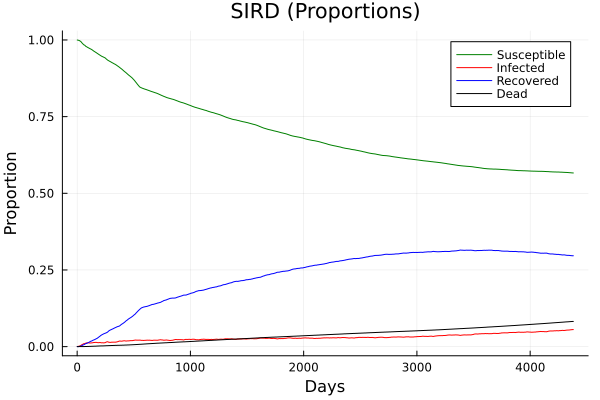

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\SIRD Curve.pdf"

In [23]:
##### Graph of proportions
x = 1:length(curves_returned[1][1])


plotd=Plots.plot(x, medians_every_point_all_curves[1], color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion")
Plots.plot!(x, medians_every_point_all_curves[2], color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, medians_every_point_all_curves[3], color = :blue,label="Recovered")
Plots.plot!(x, medians_every_point_all_curves[4], color = :black,label="Dead")
display(plotd)

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/SIRD Curve.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/SIRD Curve.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/SIRD Curve.pdf")

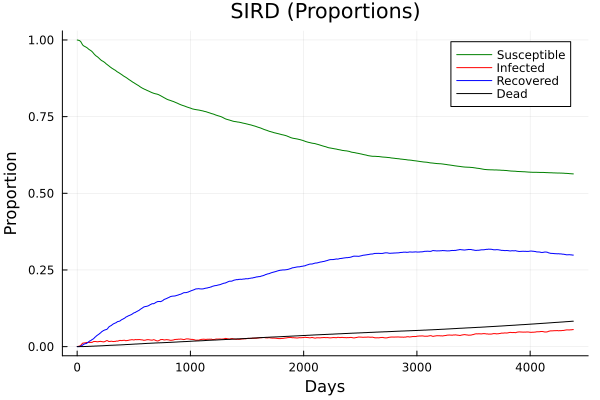

In [24]:
###### Graph of proportions
x = 1:length(curves_returned[1][1])
Plots.plot(x, curves_returned[median_index][1], color = :green,label="Susceptible",xlabel="Days",ylabel="Proportion")
Plots.plot!(x, curves_returned[median_index][2], color = :red,label="Infected",title="SIRD (Proportions)")
Plots.plot!(x, curves_returned[median_index][3], color = :blue,label="Recovered")
Plots.plot!(x, curves_returned[median_index][4], color = :black,label="Dead")

In [25]:
#Steady state calculation of prevalence, as a proportion of population (for each state)
prevalence_by_state= Dict{String,Float64}()

for state in keys(medians_every_point_all_curves[19])
    prevalence_by_state[state]=medians_every_point_all_curves[19][state]/medians_every_point_all_curves[5][state]/(medians_every_point_all_curves[21])*medians_every_point_all_curves[8]
end

#using Pickle
store("statewise_prevalence_spneumoniae_steady_state/ABM_code_no_vaccinations_(last 12 years).pkl",prevalence_by_state)

In [26]:
pop_by_quintile=Float64[]

for quintile in 1:5
    push!(pop_by_quintile,medians_every_point_all_curves[12][quintile][length(medians_every_point_all_curves[12][quintile])]-
    medians_every_point_all_curves[17][quintile][length(medians_every_point_all_curves[17][quintile])])
end

In [27]:
#Steady state calculation of prevalence, as a proportion of population (for each quintile)
prevalence_by_quintile= Dict{Int64,Float64}()

for quintile in keys(medians_every_point_all_curves[22])
    prevalence_by_quintile[quintile]=medians_every_point_all_curves[22][quintile]/pop_by_quintile[quintile]/(medians_every_point_all_curves[21])*medians_every_point_all_curves[8]
end

#using Pickle
store("quintilewise_prevalence_spneumoniae_steady_state/ABM_code_no_vaccinations_(last 12 years).pkl",prevalence_by_quintile)

In [28]:
#Steady state calculation of abx consumed per day as a relative to population (for each quintile)
prop_taking_abx_per_quintile_per_day= Dict{Int64,Float64}()

for quintile in keys(medians_every_point_all_curves[23])
    prop_taking_abx_per_quintile_per_day[quintile]=medians_every_point_all_curves[23][quintile]/pop_by_quintile[quintile]/(medians_every_point_all_curves[21])
end

#using Pickle
store("quintilewise_prop_abx_per_person_steady_state/ABM_code_no_vaccinations_(last 12 years).pkl",prop_taking_abx_per_quintile_per_day)

In [29]:
prop_taking_abx_per_state_per_day= Dict{String,Float64}()

for state in keys(medians_every_point_all_curves[19])
    prop_taking_abx_per_state_per_day[state]=medians_every_point_all_curves[20][state]/medians_every_point_all_curves[5][state]/(medians_every_point_all_curves[21])
end

#using Pickle
store("statewise_prop_abx_per_person_steady_state/ABM_code_no_vaccinations_(last 12 years).pkl",prop_taking_abx_per_state_per_day)

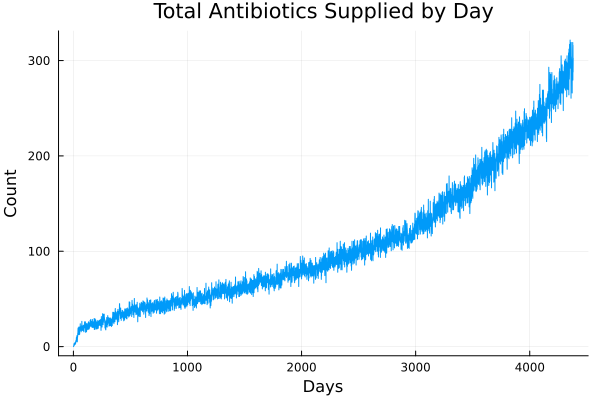

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Total Antibiotics Supplied by Day.pdf"

In [30]:
plotd=Plots.plot(x, medians_every_point_all_curves[11],title="Total Antibiotics Supplied by Day",xlabel="Days",ylabel="Count",label="")
display(plotd)

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Total Antibiotics Supplied by Day.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Total Antibiotics Supplied by Day.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Total Antibiotics Supplied by Day.pdf")

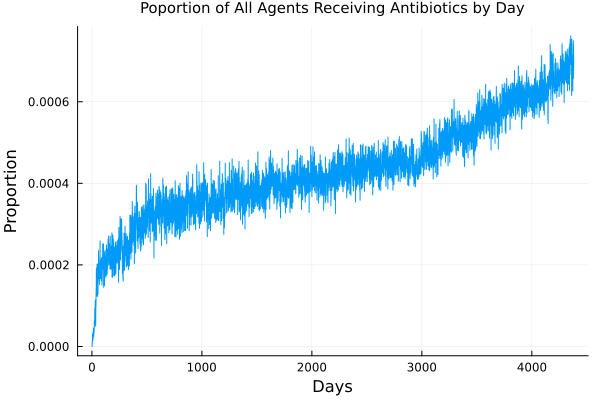

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Poportion of All Agents Receiving Antibiotics by Day.pdf"

In [31]:
#graph of proportions
plotd=Plots.plot(x, medians_every_point_all_curves[9],title="Poportion of All Agents Receiving Antibiotics by Day",xlabel="Days",ylabel="Proportion",label="",titlefontsize=10)
display(plotd)

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Poportion of All Agents Receiving Antibiotics by Day.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Poportion of All Agents Receiving Antibiotics by Day.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Poportion of All Agents Receiving Antibiotics by Day.pdf")

In [42]:
total_infected=medians_every_point_all_curves[14][1].+medians_every_point_all_curves[14][2].+medians_every_point_all_curves[14][3].+medians_every_point_all_curves[14][4].+medians_every_point_all_curves[14][5]

4381-element Vector{Float64}:
    34.5
    34.5
    36.0
    39.5
    43.5
    47.0
    53.0
    61.0
    72.5
    80.5
    89.5
    95.5
   103.0
     ⋮
 23358.0
 23437.5
 23533.0
 23537.0
 23564.5
 23573.5
 23604.0
 23594.5
 23624.0
 23582.0
 23591.0
 23587.5

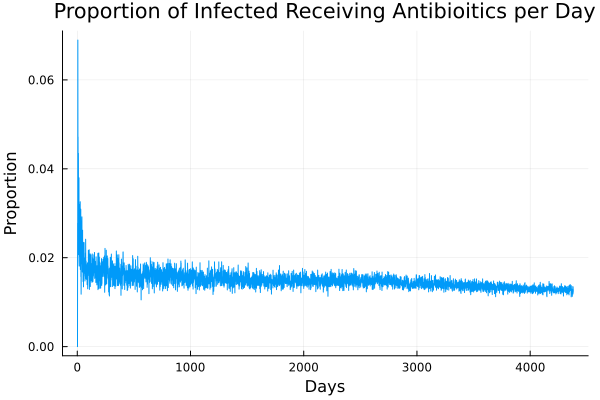

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion of Infected Receiving Antibioitics per Day.pdf"

In [43]:
#graph of proportions per infected
plotd=Plots.plot(x, medians_every_point_all_curves[11]./total_infected,title="Proportion of Infected Receiving Antibioitics per Day",xlabel="Days",ylabel="Proportion",label="")
display(plotd)

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected Receiving Antibioitics per Day.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected Receiving Antibioitics per Day.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected Receiving Antibioitics per Day.pdf")

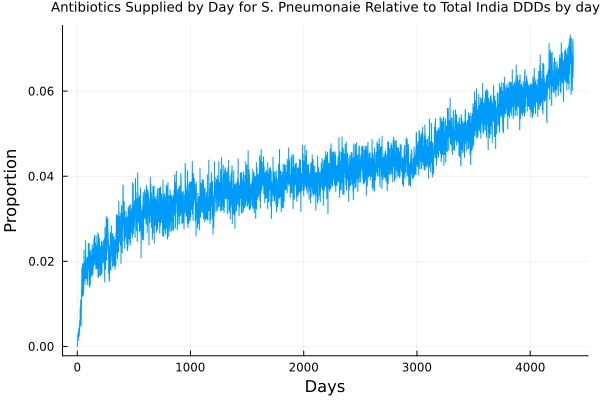

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Antibiotics Supplied by Day for S Pneumonaie Relative to Total India DDDs by day.pdf"

In [33]:
#graph of proportion of antibiotics to cover S. Pneumonaie relative to total abxs supplied (total = 10.4 DDDs per 1000 people per day)
plotd=Plots.plot(x, medians_every_point_all_curves[11]./(medians_every_point_all_curves[12][1].+medians_every_point_all_curves[12][2].+medians_every_point_all_curves[12][3].+medians_every_point_all_curves[12][4].+medians_every_point_all_curves[12][5]).*1000/10.4,
    title="Antibiotics Supplied by Day for S. Pneumonaie Relative to Total India DDDs by day",xlabel="Days",ylabel="Proportion",label="",titlefontsize=9)
display(plotd)

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Antibiotics Supplied by Day for S Pneumonaie Relative to Total India DDDs by day.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Antibiotics Supplied by Day for S Pneumonaie Relative to Total India DDDs by day.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Antibiotics Supplied by Day for S Pneumonaie Relative to Total India DDDs by day.pdf")

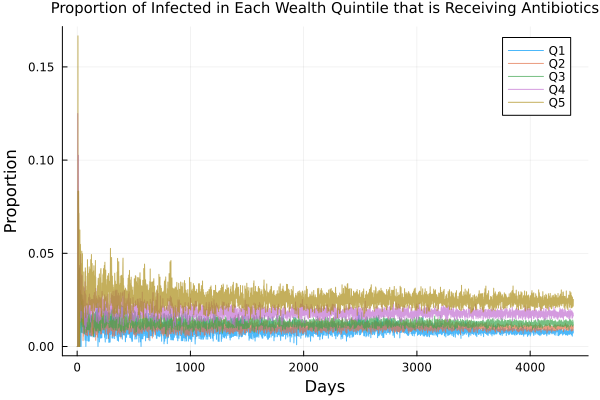

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\α_Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.pdf"

In [34]:
#Proportion of infected in each wealth quintile that is receiving antibiotics

plotd=Plots.plot(x, medians_every_point_all_curves[13][1][1:length(x)]./medians_every_point_all_curves[14][1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=10,alpha=0.7)
for quintile in 2:5
    p=Plots.plot!(x, medians_every_point_all_curves[13][quintile][1:length(x)]./medians_every_point_all_curves[14][quintile][1:length(x)],label="Q"*string(quintile),alpha=0.7)
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/α_Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/α_Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/α_Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.pdf")

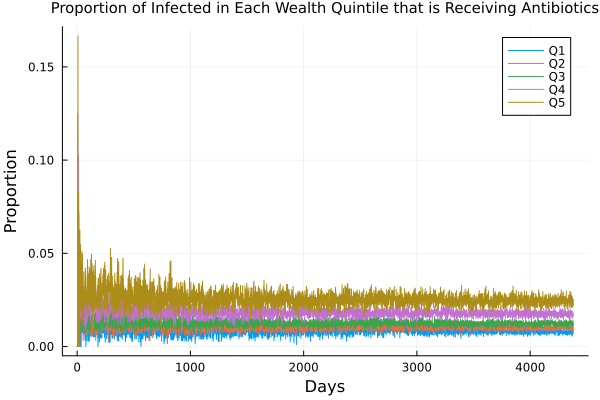

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.pdf"

In [35]:
#Proportion of infected in each wealth quintile that is receiving antibiotics

plotd=Plots.plot(x, medians_every_point_all_curves[13][1][1:length(x)]./medians_every_point_all_curves[14][1][1:length(x)],title="Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=10)
for quintile in 2:5
    p=Plots.plot!(x, medians_every_point_all_curves[13][quintile][1:length(x)]./medians_every_point_all_curves[14][quintile][1:length(x)],label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Infected in Each Wealth Quintile that is Receiving Antibiotics.pdf")

#### To change total 'community transmitted cases', should adjust "contact_transmitted" factor

In [36]:
println(medians_every_point_all_curves[15])#community transmitted
println(medians_every_point_all_curves[16])#contact transmitted

81119.0
1.5437595e6


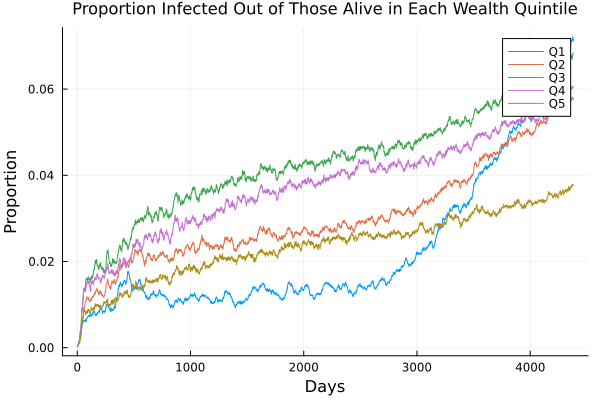

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion Infected Out of Those Alive in Each Wealth Quintile.pdf"

In [37]:
#Proportion of each wealth quintile comprised of infected

plotd=Plots.plot(x,medians_every_point_all_curves[14][1]./(medians_every_point_all_curves[12][1].-medians_every_point_all_curves[17][1]),title="Proportion Infected Out of Those Alive in Each Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5
    medians_every_point_all_curves[14][quintile]
    medians_every_point_all_curves[12][quintile]
    p=Plots.plot!(x,medians_every_point_all_curves[14][quintile]./(medians_every_point_all_curves[12][quintile].-medians_every_point_all_curves[17][quintile]),label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion Infected Out of Those Alive in Each Wealth Quintile.pdf")

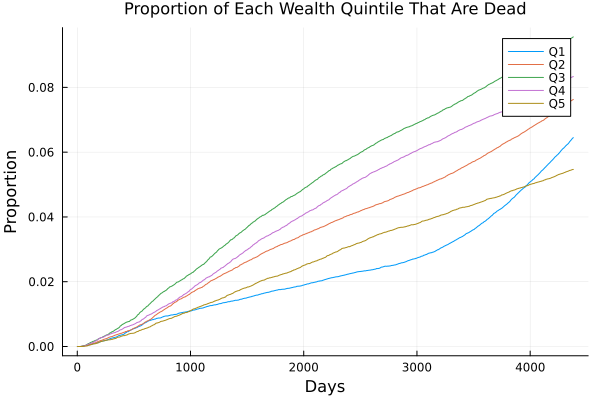

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion of Each Wealth Quintile That Are Dead.pdf"

In [38]:
#Proportion of each wealth quintile comprised of dead


plotd=Plots.plot(x,medians_every_point_all_curves[17][1]./(medians_every_point_all_curves[12][1].+medians_every_point_all_curves[17][1]),title="Proportion of Each Wealth Quintile That Are Dead",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5

    p=Plots.plot!(x,medians_every_point_all_curves[17][quintile]./(medians_every_point_all_curves[12][quintile].+medians_every_point_all_curves[17][quintile]),label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Each Wealth Quintile That Are Dead.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Each Wealth Quintile That Are Dead.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Each Wealth Quintile That Are Dead.pdf")

### Below is not very informative (does not account for the differences in wealth quintile sizes)

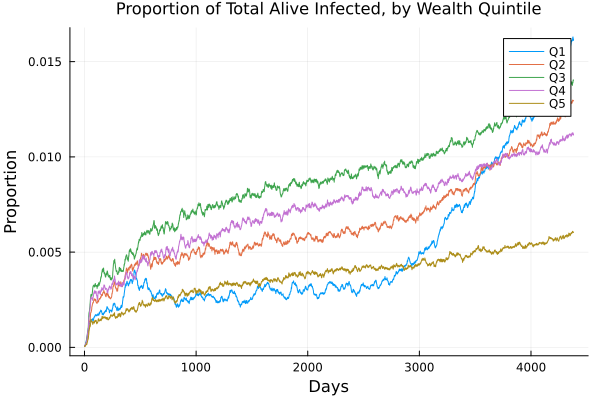

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion of Total Alive Infected, by Wealth Quintile.pdf"

In [39]:
#proportion of total alive infected, by wealth quintile



total = sum([medians_every_point_all_curves[12][i]-medians_every_point_all_curves[17][i] for i in 1:5])

plotd=Plots.plot(x,medians_every_point_all_curves[14][1]./total,title="Proportion of Total Alive Infected, by Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1",titlefontsize=11)
for quintile in 2:5
    p=Plots.plot!(x,medians_every_point_all_curves[14][quintile]./total,label="Q"*string(quintile))
    
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Alive Infected, by Wealth Quintile.pdf")

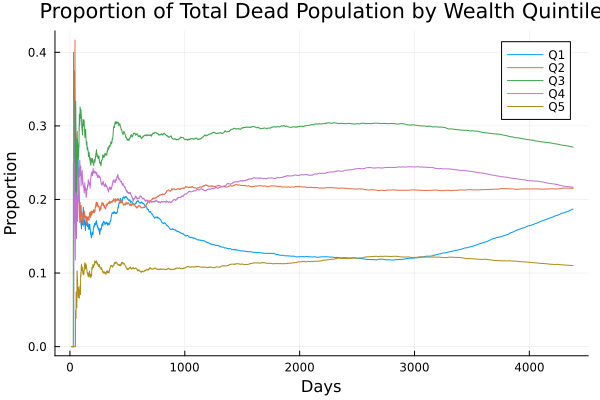

"C:\\Users\\alecm\\OneDrive\\Documents\\Dr.  Lax\\Agent-Based Modeling\\S. pneumoniae\\Plots\\ABM_code_no_vaccinations_(last 12 years)\\Proportion of Total Dead Population by Wealth Quintile.pdf"

In [40]:
#Proportion of *total dead population* by wealth quintile

plotd=Plots.plot(x,medians_every_point_all_curves[17][1]./medians_every_point_all_curves[18],title="Proportion of Total Dead Population by Wealth Quintile",xlabel="Days",ylabel="Proportion",label="Q1")
for quintile in 2:5
    p=Plots.plot!(x,medians_every_point_all_curves[17][quintile]./medians_every_point_all_curves[18],label="Q"*string(quintile))
    if quintile==5
        display(p)
    end
end

savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Dead Population by Wealth Quintile.png")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Dead Population by Wealth Quintile.svg")
savefig(plotd,"Plots/ABM_code_no_vaccinations_(last 12 years)/Proportion of Total Dead Population by Wealth Quintile.pdf")